### Import libraries 📚

In [4]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Load the dataset 📅

In [18]:
train_data_dir = './Training'
file_paths = []
labels = []

folder_list = os.listdir(train_data_dir)
for folder in folder_list:
    foldpath = os.path.join(train_data_dir, folder)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        file_paths.append(fpath)
        labels.append(folder)

Fseries = pd.Series(file_paths, name='file_paths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis=1)

### Make data frame of images to their corresponding labels 🔖

In [19]:
test_data_dir = './Testing'
file_paths = []
labels = []
folder_list = os.listdir(test_data_dir)

# Iterate over the list of folders
for folder in folder_list:
    # Create a list of filepaths
    folder_path = os.path.join(test_data_dir,folder)
    file_list = os.listdir(folder_path)

    # Iterate over the list of files
    for file in file_list:
        file_path = os.path.join(folder_path,file)
        file_paths.append (file_path)
        labels.append(folder)
# Create a pandas series
Fseries = pd.Series(file_paths,name = 'file_paths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')

print(dt)

                              file_paths     labels
0      ./Testing\glioma\Te-glTr_0000.jpg     glioma
1      ./Testing\glioma\Te-glTr_0001.jpg     glioma
2      ./Testing\glioma\Te-glTr_0002.jpg     glioma
3      ./Testing\glioma\Te-glTr_0003.jpg     glioma
4      ./Testing\glioma\Te-glTr_0004.jpg     glioma
...                                  ...        ...
1306  ./Testing\pituitary\Te-pi_0295.jpg  pituitary
1307  ./Testing\pituitary\Te-pi_0296.jpg  pituitary
1308  ./Testing\pituitary\Te-pi_0297.jpg  pituitary
1309  ./Testing\pituitary\Te-pi_0298.jpg  pituitary
1310  ./Testing\pituitary\Te-pi_0299.jpg  pituitary

[1311 rows x 2 columns]


### Split the dataset into training and testing 🧪

In [20]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

### Create image generators for training, testing, and validation 📃

In [21]:
batch_size=16
img_size = (224,224)
channels = 3
img_shape=(img_size[0], img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Image generator for training
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'file_paths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

# Image generator for testing
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'file_paths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)

# Image generator for validation
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'file_paths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


### Plot 16 images from the training generator 📷

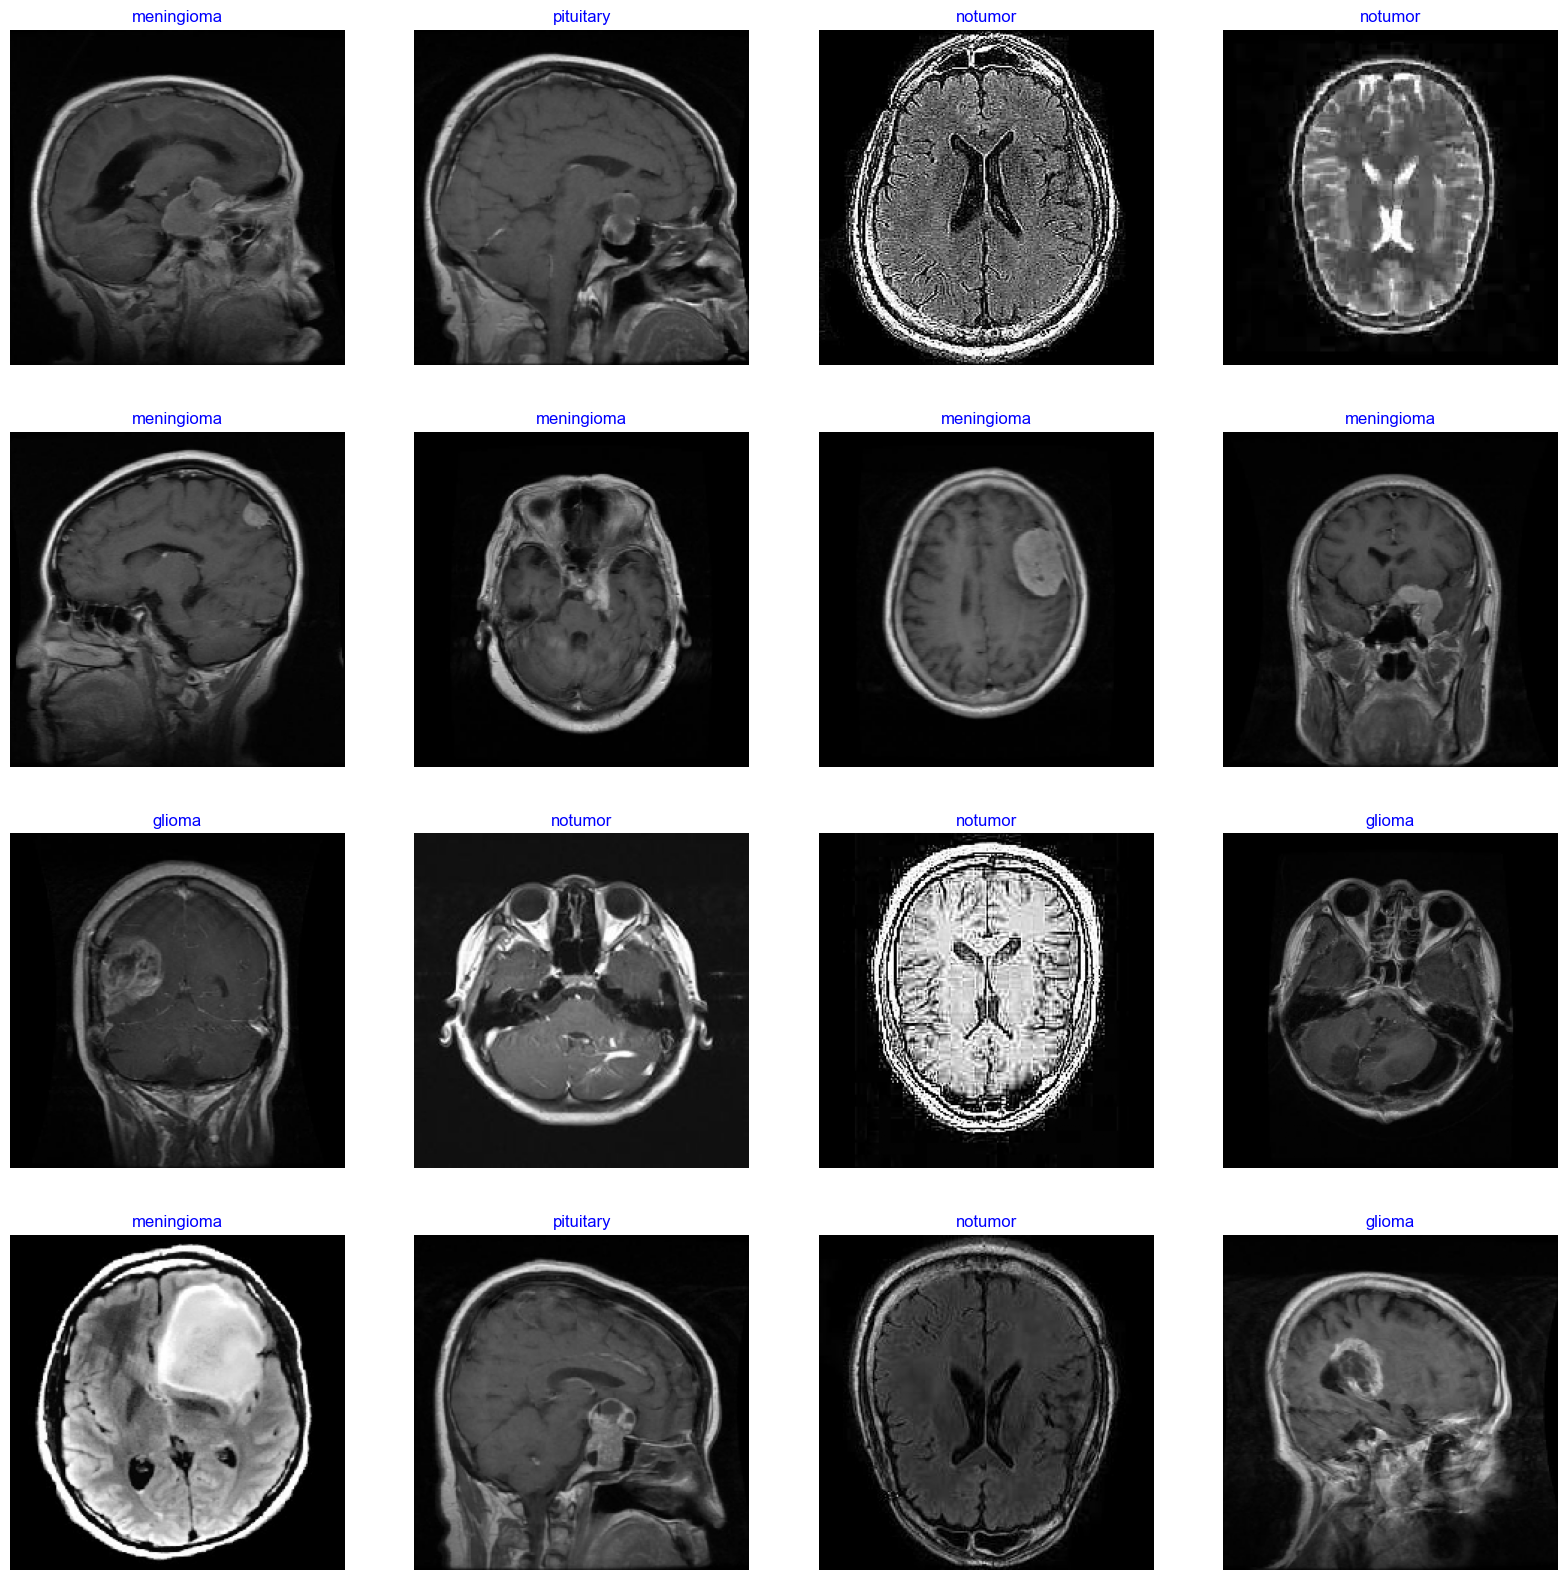

In [22]:
# Get the dictionary mapping class names to class indices
g_dict = train_gen.class_indices

# Extract class names into a list
classes = list(g_dict.keys())

# Fetch the next batch of 16 images and labels from the training generator
images, labels = next(train_gen)
plt.figure(figsize=(20, 20))

# Loop through the first 16 images
for i in range(16):
    plt.subplot(4, 4, i + 1)
    
    # Normalize the image for proper display (0–1 range)
    image = images[i] / 255
    plt.imshow(image)
    
    # Get the index of the class with highest probability (one-hot decoding)
    index = np.argmax(labels[i])
    
    # Get the class name corresponding to the index
    class_name = classes[index]
    
    # Set the title of the subplot as the class name
    plt.title(class_name, color='blue', fontsize=12)
    
    # Hide the axes for a cleaner look
    plt.axis('off')

# Show the plot
plt.show()


### Building and compile the EfficientNetB3-Based Image Classification Model 🔧


In [23]:
# Define input image size and channels 
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Get the number of classes
class_count = len(list(train_gen.class_indices.keys()))

# Load EfficientNetB3 as the base model (without top classification layer)
# Use pretrained weights from ImageNet, and apply global max pooling
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

# Build the full classification model using Keras Sequential API
model = Sequential([
    base_model, # Pretrained feature extractor
    # Normalize the outputs from the base model
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    # Dense layer with ReLU activation and regularization
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),

    # Dropout for reducing overfitting
    Dropout(rate= 0.45, seed= 123),

    # Final output layer with softmax activation
    Dense(class_count, activation= 'softmax')
])

# Compile the model with Adamax optimizer and categorical crossentropy loss
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "sequential_1"

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

### Fit the model to the training data 🚀

In [ ]:
epochs = 20
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
277/357 ━━━━━━━━━━━━━━━━━━━━ 6:02 5s/step - accuracy: 0.6141 - loss: 11.5509

### Print accuracy 🔍

In [ ]:
print(f"Training Accuracy: {history.history['accuracy'][-1]*100}%")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]*100}%")

Training Accuracy: 0.9978991746902466
Validation Accuracy: 0.9984732866287231


### Visualizing training and validation loss and accuracy 📈

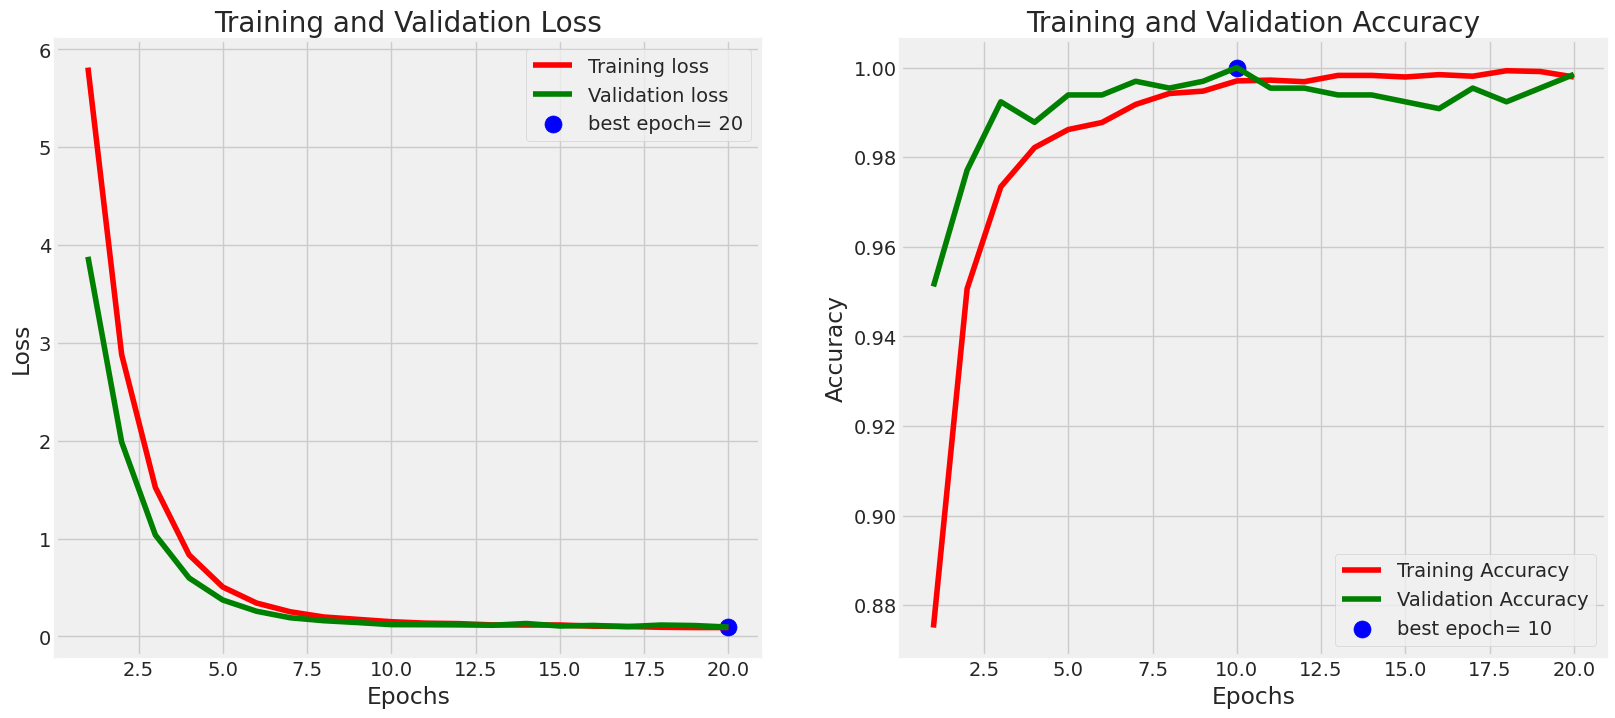

In [ ]:
# Extract training and validation accuracy and loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Find the epoch with the lowest validation loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

# Find the epoch with the highest validation accuracy
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create a list of epoch numbers for plotting
Epochs = [i+1 for i in range(len(tr_acc))]

# Prepare labels to annotate best performance epochs on the plot
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Set figure size and style
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')


# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout and show plot
plt.tight_layout
plt.show()

### Final Evaluation on Train, Validation, and Test Sets 📊

In [ ]:
# Evaluate model on the training data & store the accuracy/loss
train_score = model.evaluate(train_gen ,  verbose = 1)

# Evaluate model on the validation data & store the accuracy/loss
valid_score = model.evaluate(valid_gen ,  verbose = 1)

# Evaluate model on the test data & store the accuracy/loss
test_score = model.evaluate(test_gen ,  verbose = 1)

41/41 [==============================] - 241s 6s/step - loss: 0.0959 - accuracy: 0.9970


### Predicting Classes from Test Data 🧠

In [ ]:
# Predict class probabilities for all samples in the test set
predictions = model.predict_generator(test_gen)

# Convert predicted probabilities to class indices by taking the index with the highest probability
y_predictions = np.argmax(predictions , axis = 1)

### Confusion Matrix for Model Predictions 🔍

In [ ]:
# Get the mapping of class names to class indices from the test generator
g_dict = test_gen.class_indices

# Extract class names as a list (ordered by index)
classes = list(g_dict.keys())

# Compute the confusion matrix by comparing true labels with predicted labels
cm = confusion_matrix(test_gen.classes, y_predictions)

# Print the raw confusion matrix
print(cm)

array([[148,   1,   0,   0],
       [  0, 150,   0,   0],
       [  0,   0, 193,   0],
       [  0,   1,   0, 163]])

### Visualizing the Confusion Matrix as a Heatmap 📊

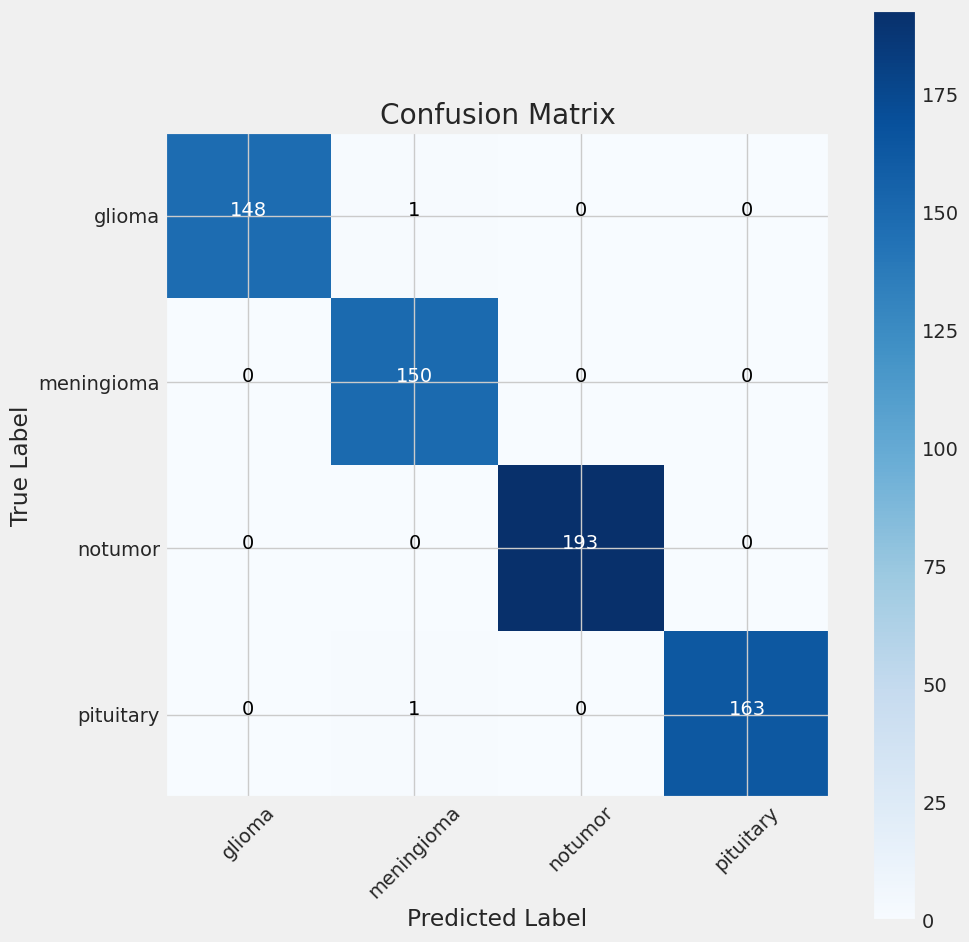

In [ ]:
# Set the figure size for the confusion matrix plot
plt.figure(figsize=(10, 10))

# Display the confusion matrix as an image with blue color scale
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Set the title and colorbar
plt.title('Confusion Matrix')
plt.colorbar()

# Create tick marks for each class and label the axes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Set threshold to determine text color (white or black for better visibility)
thresh = cm.max() / 2.

# Annotate each cell in the confusion matrix with its value
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

# Improve layout and label the axes
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Display the plot
plt.show()


### Save the model 🚀

In [18]:
model.save("Model.h5")